# Batch computation of timeseries

In [2]:
import openeo
import geopandas as gpd

In [23]:
ll /data/users/Public/kristofvt/data/BELCAM/fields/tesfields.shp

-rw-r--r--. 1 39370 12460 Aug  9 13:21 /data/users/Public/kristofvt/data/BELCAM/fields/tesfields.shp


In [3]:
fields_file = "/data/users/Public/kristofvt/data/BELCAM/fields/tesfields.shp"
fields_file = "/data/users/Public/driesj/flanders_2017.geojson"
fields = gpd.read_file(fields_file)
fields.crs

{'init': 'epsg:4326'}

In [6]:
len(fields)

65811

## Filter out overlapping fields

When parcels do not overlap (which is the most logical case), the geopyspark backend will use an optimized implementation to compute the timeseries, which is much faster. Therefore we explicitly filter out overlapping fields on the clients side.

We can still retrieve the results for the overlapping fields in a separate call if needed.

In [ ]:
from tqdm import tqdm
#from tqdm._tqdm_notebook import tqdm_notebook
import pandas as pd
#tqdm.pandas()
from joblib import Parallel, delayed

fields['id'] = fields.CODE_OBJ
data_temp=fields#.head(20000)
data_overlaps=gpd.GeoDataFrame(crs=data_temp.crs)

def get_overlap(index, row):
    data_temp1=data_temp.loc[data_temp.id!=row.id,]
    # check if intersection occured
    overlaps=data_temp1[data_temp1.geometry.overlaps(row.geometry)]['id'].tolist()
    if len(overlaps)>0:
        temp_list=[]
        #print(index)
        # compare the area with threshold
        areas = []
        for y in overlaps:
            temp_area=gpd.overlay(data_temp.loc[data_temp.id==y,],data_temp.loc[data_temp.id==row.id,],how='intersection')
            temp_area=temp_area.loc[temp_area.geometry.area>=9e-9]
            if temp_area.shape[0]>0:
                #print("found overlap")
                #
                areas.append(temp_area)
        return areas
    return []

result = Parallel(n_jobs=20)(delayed(get_overlap)(index,row) for index,row in tqdm(data_temp.iterrows(), total=data_temp.shape[0]))

    


 62%|██████▏   | 40523/65811 [19:26<12:07, 34.74it/s]

In [57]:
[r for r in result if len(r) !=0 ]

[[         CODE_OBJ_1              id_1        CODE_OBJ_2              id_2  \
  0  000028045E899370  000028045E899370  00002804615FE242  00002804615FE242   
  
                                              geometry  
  0  POLYGON ((2.643895977677292 50.93755735006403,...  ],
 [         CODE_OBJ_1              id_1        CODE_OBJ_2              id_2  \
  0  0000280464C3ADC5  0000280464C3ADC5  0000280449EC7BAE  0000280449EC7BAE   
  
                                              geometry  
  0  POLYGON ((4.583325356837074 50.96771820131161,...  ],
 [         CODE_OBJ_1              id_1        CODE_OBJ_2              id_2  \
  0  0000280464D4823D  0000280464D4823D  0000280449BAFC05  0000280449BAFC05   
  
                                              geometry  
  0  POLYGON ((5.043086333118302 50.80316320909422,...  ],
 [         CODE_OBJ_1              id_1        CODE_OBJ_2              id_2  \
  0  0000280464A0ADD0  0000280464A0ADD0  000028045E0BB56A  000028045E0BB56A   
  
        

In [58]:
for r in result:
    if(len(r)!=0):
        for temp_area in r:
            data_overlaps=gpd.GeoDataFrame(pd.concat([temp_area,data_overlaps],ignore_index=True),crs=data_temp.crs)
data_overlaps

,CODE_OBJ_1,id_1,CODE_OBJ_2,id_2,geometry
0,0000280463DAB9DF,0000280463DAB9DF,0000280464D48C1E,0000280464D48C1E,"POLYGON ((5.113778637440823 50.79831972183585,..."
1,00002804615A4988,00002804615A4988,0000280464D48BB9,0000280464D48BB9,"POLYGON ((5.105380884580798 50.79097329780861,..."
2,000028045DE98C92,000028045DE98C92,0000280464D48957,0000280464D48957,"POLYGON ((5.162375495398581 50.81129373942198,..."
3,0000280464D0729F,0000280464D0729F,0000280464D488F2,0000280464D488F2,"POLYGON ((5.149377800303584 50.7909742627814, ..."
4,0000280462083A83,0000280462083A83,0000280464D483D1,0000280464D483D1,"POLYGON ((5.125132179643018 50.81775168677544,..."
5,0000280449BAFC05,0000280449BAFC05,0000280464D4823D,0000280464D4823D,"POLYGON ((5.043091786036498 50.80317550147208,..."
6,0000280460881426,0000280460881426,0000280464D48173,0000280464D48173,"POLYGON ((5.058829981605482 50.7415649147796, ..."
7,00002804608812F7,00002804608812F7,0000280464D48173,0000280464D48173,"POLYGON ((5.056715905911707 50.74241616930497,..."
8,000028045B021B83,000028045B021B83,0000280464D2A7D3,0000280464D2A7D3,"POLYGON ((4.403535623640475 50.94929073881368,..."
9,0000280464CDD274,0000280464CDD274,0000280464D2574F,0000280464D2574F,"POLYGON ((3.075284428137326 51.25483710594298,..."


In [59]:
# get unique of list id
data_overlaps['sorted']=data_overlaps.apply(lambda y: sorted([y['id_1'],y['id_2']]),axis=1)
data_overlaps['sorted']=data_overlaps.sorted.apply(lambda y: ''.join(y))
data_overlaps=data_overlaps.drop_duplicates('sorted')
data_overlaps=data_overlaps.reset_index()[['id_1','id_2','geometry']]
data_overlaps

,id_1,id_2,geometry
0,0000280463DAB9DF,0000280464D48C1E,"POLYGON ((5.113778637440823 50.79831972183585,..."
1,00002804615A4988,0000280464D48BB9,"POLYGON ((5.105380884580798 50.79097329780861,..."
2,000028045DE98C92,0000280464D48957,"POLYGON ((5.162375495398581 50.81129373942198,..."
3,0000280464D0729F,0000280464D488F2,"POLYGON ((5.149377800303584 50.7909742627814, ..."
4,0000280462083A83,0000280464D483D1,"POLYGON ((5.125132179643018 50.81775168677544,..."
5,0000280449BAFC05,0000280464D4823D,"POLYGON ((5.043091786036498 50.80317550147208,..."
6,0000280460881426,0000280464D48173,"POLYGON ((5.058829981605482 50.7415649147796, ..."
7,00002804608812F7,0000280464D48173,"POLYGON ((5.056715905911707 50.74241616930497,..."
8,000028045B021B83,0000280464D2A7D3,"POLYGON ((4.403535623640475 50.94929073881368,..."
9,0000280464CDD274,0000280464D2574F,"POLYGON ((3.075284428137326 51.25483710594298,..."


In [61]:
data_overlaps['area'] = data_overlaps.to_crs({'init': 'epsg:32631'}).geometry.area
data_overlaps

,id_1,id_2,geometry,area
0,0000280463DAB9DF,0000280464D48C1E,"POLYGON ((5.113778637440823 50.79831972183585,...",13889.248375
1,00002804615A4988,0000280464D48BB9,"POLYGON ((5.105380884580798 50.79097329780861,...",12427.115498
2,000028045DE98C92,0000280464D48957,"POLYGON ((5.162375495398581 50.81129373942198,...",7178.497560
3,0000280464D0729F,0000280464D488F2,"POLYGON ((5.149377800303584 50.7909742627814, ...",21526.248202
4,0000280462083A83,0000280464D483D1,"POLYGON ((5.125132179643018 50.81775168677544,...",29222.763700
5,0000280449BAFC05,0000280464D4823D,"POLYGON ((5.043091786036498 50.80317550147208,...",2930.084163
6,0000280460881426,0000280464D48173,"POLYGON ((5.058829981605482 50.7415649147796, ...",23864.858194
7,00002804608812F7,0000280464D48173,"POLYGON ((5.056715905911707 50.74241616930497,...",26449.988214
8,000028045B021B83,0000280464D2A7D3,"POLYGON ((4.403535623640475 50.94929073881368,...",8772.508572
9,0000280464CDD274,0000280464D2574F,"POLYGON ((3.075284428137326 51.25483710594298,...",31511.000388


In [62]:
non_overlap = fields
for id in data_overlaps.id_1:
    #print(id)
    non_overlap = non_overlap[non_overlap.CODE_OBJ != id]

In [69]:
non_overlap.head(25000).to_file("/data/users/Public/driesj/fields_flanders_non_overlap.shp")

/opt/rh/rh-python35/root/usr/lib/python3.5/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


## Create and submit batch job

For timeseries computation on large files, it is more robust to use batch jobs as they do not run the risk of being interrupted by network timeouts.

In [81]:
import openeo

session = openeo.connect("http://openeo.vgt.vito.be/openeo/0.4.0")
 

asc = session.imagecollection('S1_GRD_SIGMA0_ASCENDING').date_range_filter('2019-01-01', '2019-01-31')\
.bbox_filter(west=3, east=6, north=52, south=50, crs='EPSG:4326')

timeseries_job = asc.polygonal_mean_timeseries("/data/users/Public/driesj/fields_flanders_non_overlap.shp").send_job(out_format="json")

In [82]:
timeseries_job.describe_job()

{'job_id': 'bfc0a931-3106-4839-8ac0-0055035ee0c6', 'status': 'submitted'}

In [83]:
timeseries_job.start_job()

202

In [84]:
timeseries_job.describe_job()

{'job_id': 'bfc0a931-3106-4839-8ac0-0055035ee0c6', 'status': 'queued'}

In [85]:
timeseries_job.describe_job()

{'job_id': 'bfc0a931-3106-4839-8ac0-0055035ee0c6', 'status': 'error'}

In [134]:
timeseries_job.download_results('timeseries.json')

200

In [135]:
import json
with open('timeseries.json','r') as f:
    ts_json = json.load(f)

In [136]:
import pandas as pd
timeseries_dataframe = pd.DataFrame(ts_json)
timeseries_dataframe.head()

,2019-01-01T00:00:00Z,2019-01-02T00:00:00Z,2019-01-03T00:00:00Z,2019-01-04T00:00:00Z,2019-01-05T00:00:00Z,2019-01-06T00:00:00Z,2019-01-07T00:00:00Z,2019-01-08T00:00:00Z,2019-01-09T00:00:00Z,2019-01-10T00:00:00Z,...,2019-01-22T00:00:00Z,2019-01-23T00:00:00Z,2019-01-24T00:00:00Z,2019-01-25T00:00:00Z,2019-01-26T00:00:00Z,2019-01-27T00:00:00Z,2019-01-28T00:00:00Z,2019-01-29T00:00:00Z,2019-01-30T00:00:00Z,2019-01-31T00:00:00Z
0,NaN,NaN,NaN,NaN,0.015973,0.020273,NaN,NaN,NaN,NaN,...,NaN,0.004181,0.003757,NaN,NaN,NaN,NaN,0.014117,0.009968,NaN
1,NaN,NaN,NaN,NaN,0.018153,0.017165,NaN,NaN,NaN,NaN,...,NaN,0.003463,0.002971,NaN,NaN,NaN,NaN,0.013818,0.011603,NaN
2,NaN,NaN,NaN,0.035823,0.041914,NaN,NaN,NaN,NaN,0.015535,...,0.005253,0.007584,NaN,NaN,NaN,NaN,0.025215,0.027362,NaN,NaN
3,NaN,NaN,NaN,NaN,0.016385,NaN,NaN,NaN,NaN,NaN,...,NaN,0.008733,NaN,NaN,NaN,NaN,NaN,0.012746,NaN,NaN
4,NaN,NaN,NaN,NaN,0.014201,0.017463,NaN,NaN,NaN,NaN,...,NaN,0.004269,0.003235,NaN,NaN,NaN,NaN,0.010503,0.009020,NaN


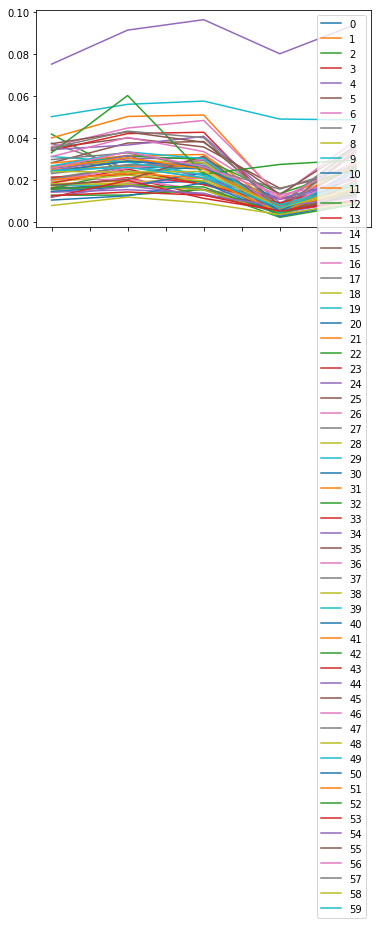

In [137]:
%matplotlib inline
timeseries_dataframe.T.dropna().plot()